# Análisis del dataset Wiki Movie Plots

Importa las librarías que se usaran

In [1]:
import os

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

plt.style.use('ggplot')

In [2]:
wiki_plots = pd.read_csv("wiki_movie_plots_deduped.csv")
wiki_plots.rename(columns={'Origin/Ethnicity':'Origin'}, inplace=True) # para mayor comodidad
wiki_plots = wiki_plots.drop_duplicates(subset='Plot', keep='first')
wiki_plots.shape

(33869, 8)

Muestra de los primeros datos

In [3]:
wiki_plots.head(3)

,Release Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."


### Descripción de las columnas

La base de datos contiene descripciones para 34,886 películas de todo el mundo. las columnas son las siguientes:

- Release Year - Año en que se estreno la película
- Title - Titulo de la película
- Origin/Ethnicity - Origen de la pelicula (e.g. America, Bollywood, Tamil, etc)
- Director - Director(s)
- Cast - Actores y actrices principales
- Genre - Genero(s) de la película
- Wiki Page - URL de la pagina de Wikipedia de la cual la descripción de la trama fue tomada
- Plot - descripción larga de la trama de la película (ADVERTENCIA: puede contener espoilers)

In [4]:
wiki_plots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33869 entries, 0 to 34885
Data columns (total 8 columns):
Release Year    33869 non-null int64
Title           33869 non-null object
Origin          33869 non-null object
Director        33869 non-null object
Cast            32554 non-null object
Genre           33869 non-null object
Wiki Page       33869 non-null object
Plot            33869 non-null object
dtypes: int64(1), object(7)
memory usage: 2.3+ MB


In [5]:
wiki_plots.describe()

,Release Year
count,33869.000000
mean,1980.968555
std,27.851760
min,1901.000000
25%,1956.000000
50%,1988.000000
75%,2006.000000
max,2017.000000


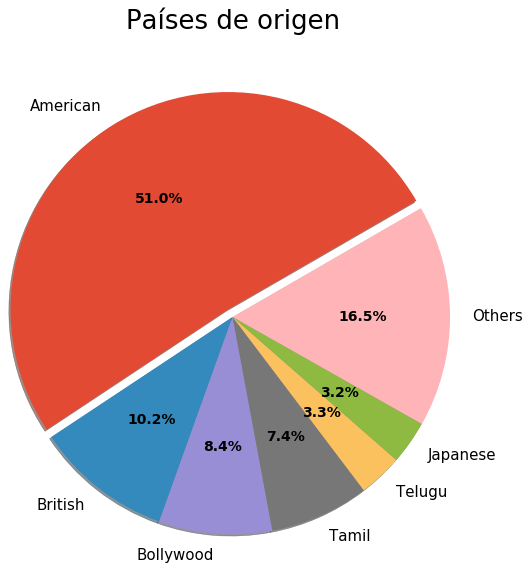

In [6]:
fig, ax = plt.subplots()
_, texts, autotexts = ax.pie(list(wiki_plots['Origin'].value_counts()[:6].values) + [sum(wiki_plots['Origin'].value_counts()[6:])], 
                    explode=(0.1, 0, 0, 0, 0, 0, 0), 
                    labels=list(wiki_plots['Origin'].value_counts()[:6].index) + ["Others"], 
                    autopct='%1.1f%%',
                    shadow=True, radius=2.5, 
                    startangle=30)

ax.set_title('Países de origen', fontsize=26, loc="center",  y=1.8)
plt.setp(texts, size=15)
plt.setp(autotexts, size=14, weight="bold")
print()

### Número de películas por año

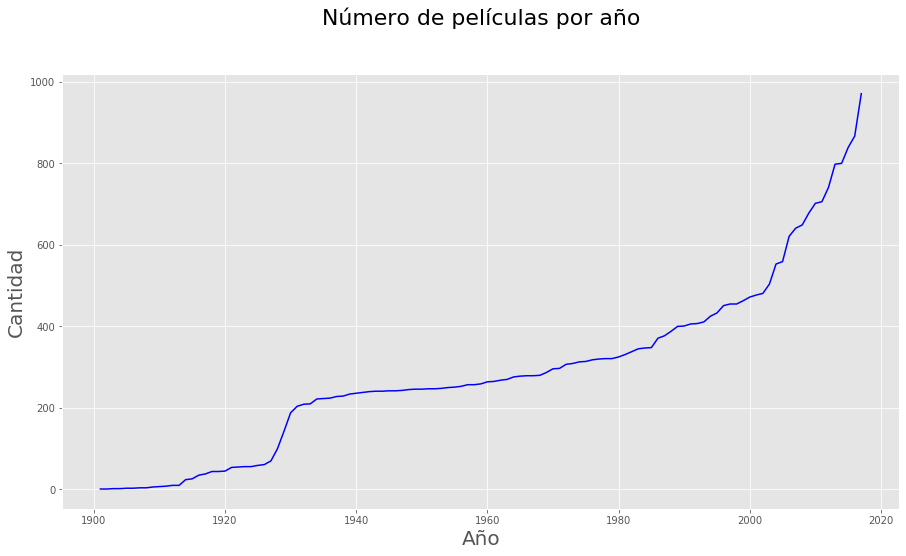

In [7]:
plt.figure(figsize=(15,8))
plt.title('Número de películas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
ax = plt.plot(wiki_plots['Release Year'].unique()[::-1], wiki_plots['Release Year'].value_counts(), 'b-')

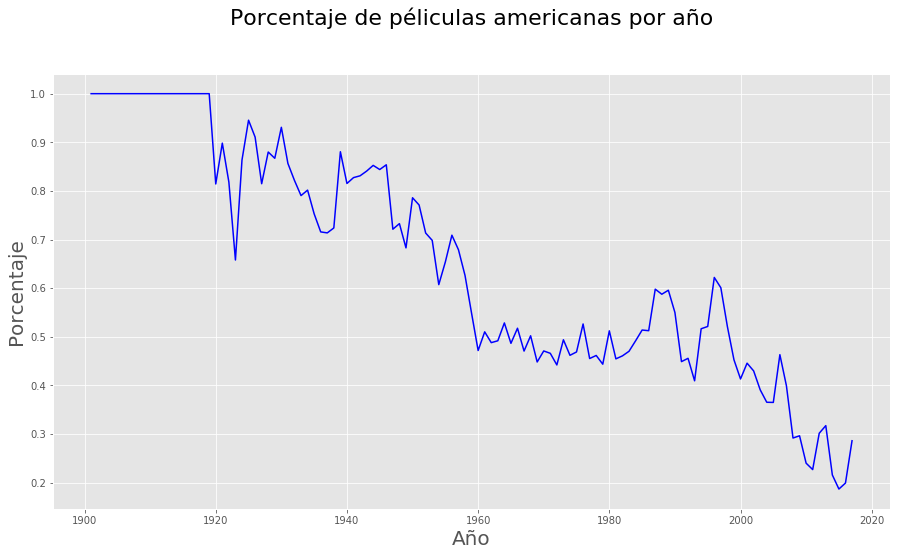

In [8]:
american_movies = wiki_plots.query('Origin == "American"')['Release Year'].value_counts()
anywhere_movies = wiki_plots['Release Year'].value_counts()

percentages = american_movies.divide(anywhere_movies)

plt.figure(figsize=(15,8))
plt.title('Porcentaje de péliculas americanas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Porcentaje', fontsize=20)
ax = plt.plot(wiki_plots['Release Year'].unique()[::-1], percentages[::-1], 'b-')

### Número de géneros distintos

In [9]:
len(wiki_plots['Genre'].unique())

2192

Text(0, 0.5, 'Número de ocurrencias')

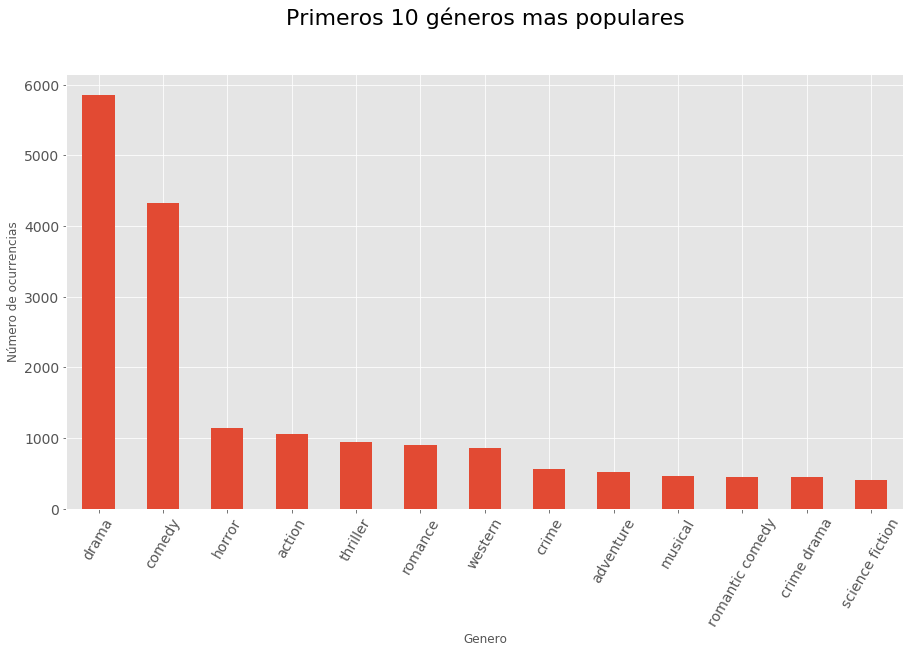

In [10]:
Genre = wiki_plots.query('Genre != "unknown"')['Genre'].value_counts()
ax = Genre[:13].plot(kind='bar', figsize=(15,8), fontsize=14)
ax.set_title('Primeros 10 géneros mas populares', size=22, y=1.1)
plt.xticks(rotation=60)
plt.xlabel('Genero')
plt.ylabel('Número de ocurrencias')

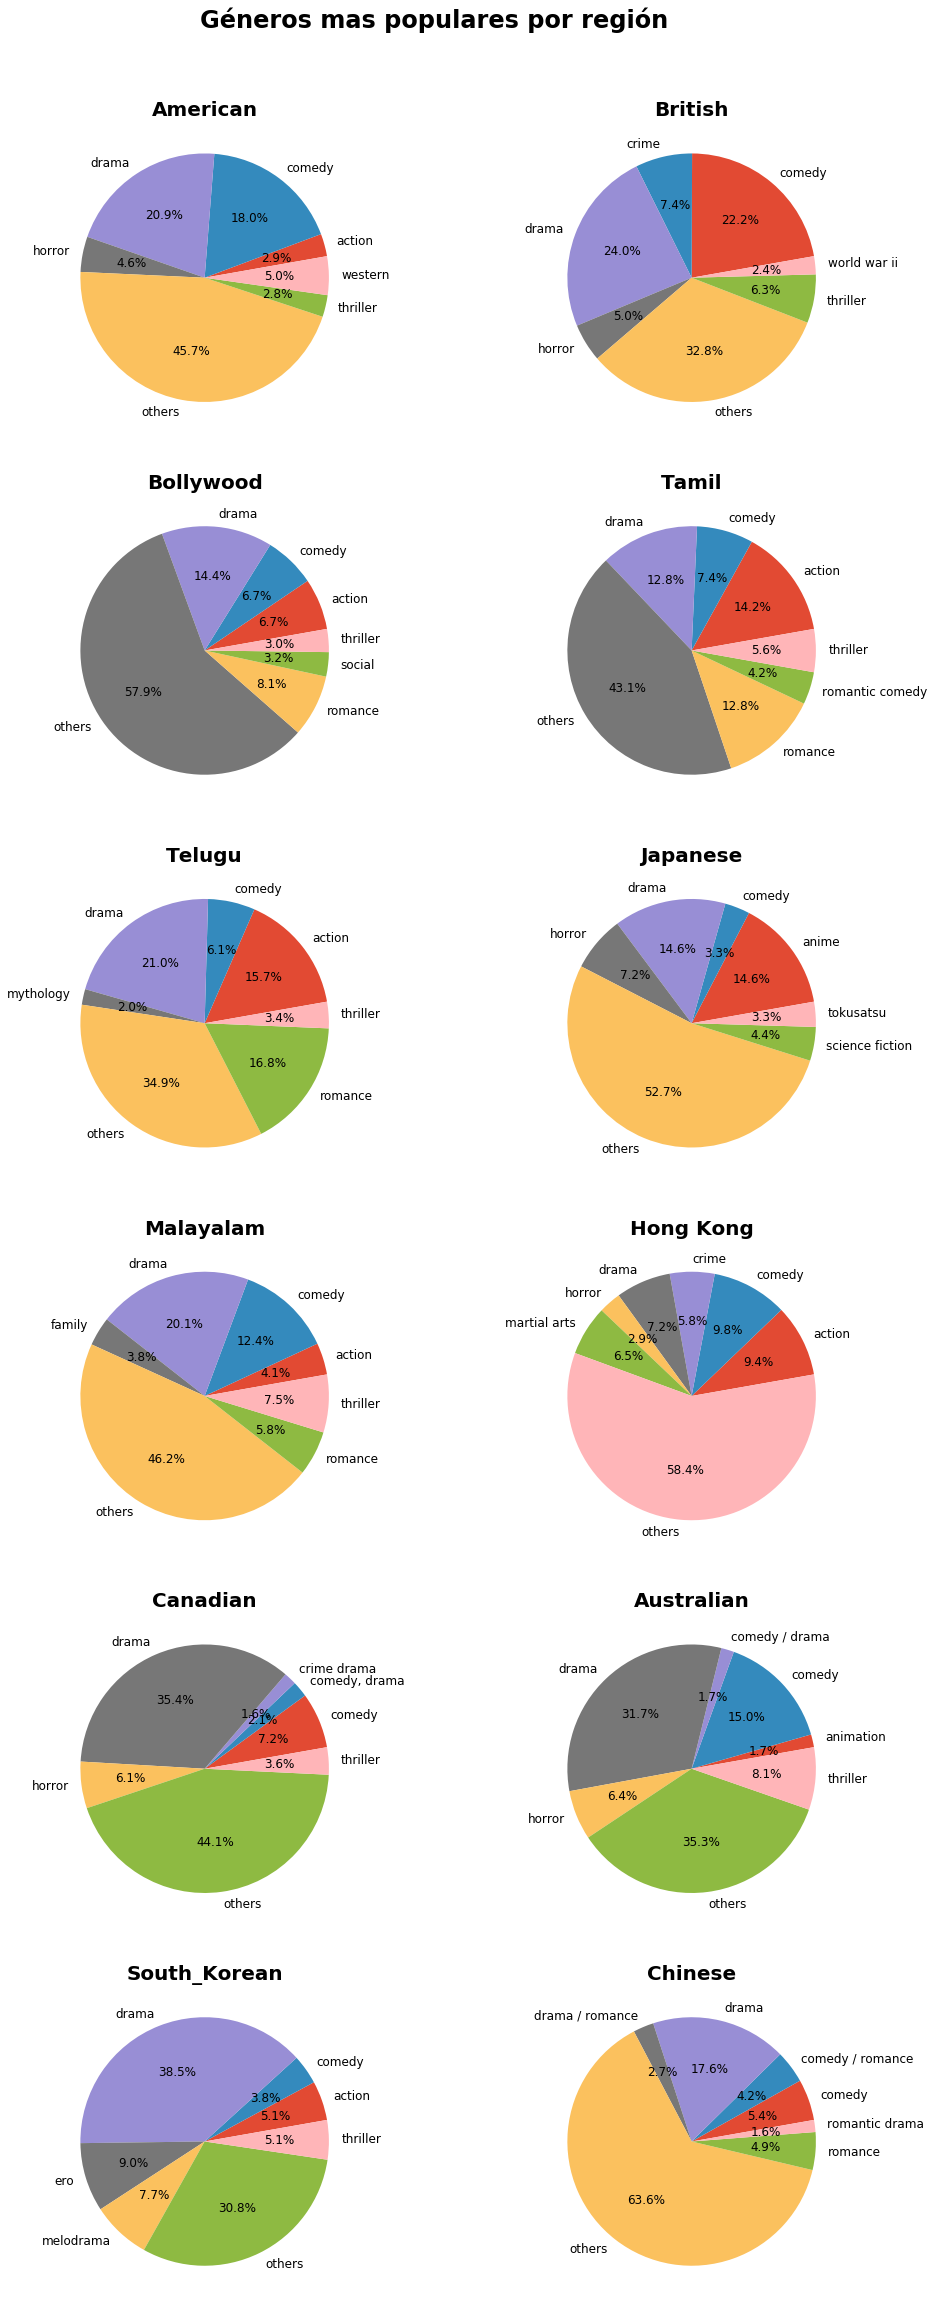

In [11]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por región", fontsize=24, y=0.92, weight="bold")

for i, origin in enumerate(wiki_plots['Origin'].value_counts().head(12).index):
    populars = wiki_plots.query(f'(Origin == "{origin}") & (Genre != "unknown")')['Genre'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], kind='pie', 
                                                                         fontsize=12, autopct='%1.1f%%', 
                                                                         figsize=(16,40), startangle=10, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{origin}", fontsize=20, weight="bold")

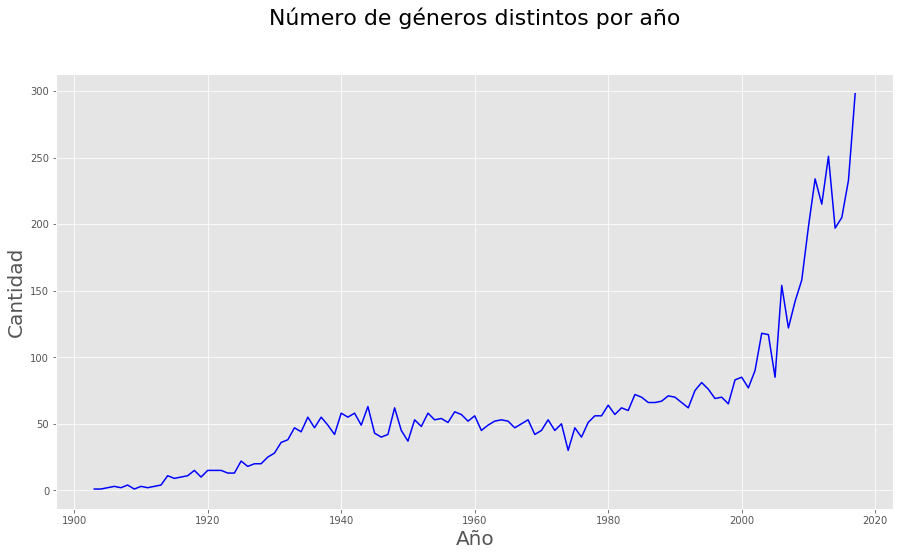

In [12]:
print()
plt.figure(figsize=(15,8))
plt.title('Número de géneros distintos por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
genres_per_year = wiki_plots.query('Genre != "unknown"').groupby('Release Year')['Genre'].nunique()
ax = plt.plot(genres_per_year.index,
              genres_per_year, 'b-')

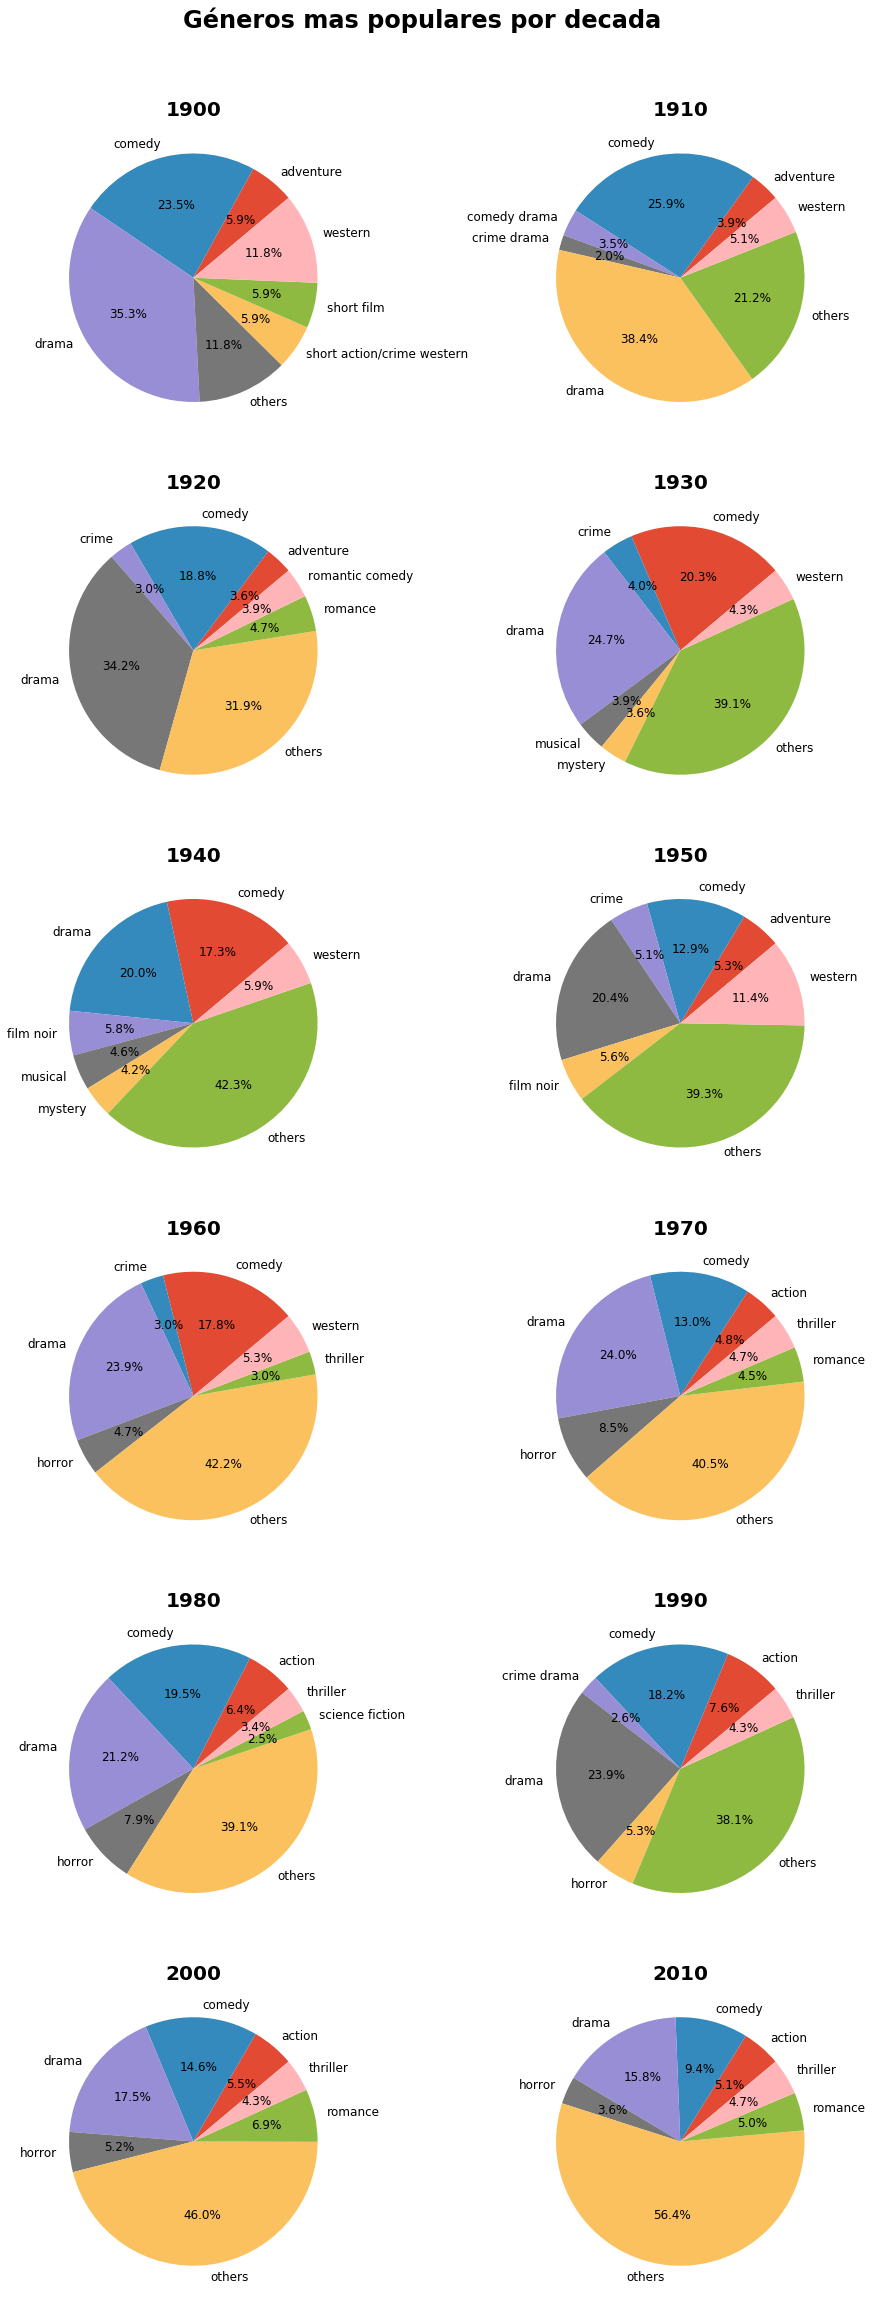

In [13]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por decada", fontsize=24, y=0.92, weight="bold")

for i, decade in enumerate(range(1900,2017,10)):
    populars = wiki_plots.query(f'`Release Year` >= {decade} & `Release Year` < {decade+10} & Genre != "unknown"')['Genre'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], 
                                                                         kind='pie', 
                                                                         fontsize=12, 
                                                                         autopct='%1.1f%%', 
                                                                         figsize=(16,40), 
                                                                         startangle=40, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{decade}", fontsize=20, weight="bold")

### Algunos ejemplos de tramas

In [22]:
def print_plot(index):
    print(f'{wiki_plots["Title"][index]} - {wiki_plots["Release Year"][index]}')
    print("")
    print(wiki_plots['Plot'][index])

print_plot(342)
print("\n------------\n")
print_plot(7347)
print("\n------------\n")
print_plot(5)

Old Lady 31 - 1920

Based upon a summary of the plot in a review in a film publication,[3] Angie (Dunn) and Abe (Harmon) have been married for many years when bad investments force them to sell their homestead. Angie is to go to the old ladies' home while Abe is to go to live on the poor farm. When the twenty-nine inmates of the old ladies' home see how hard it is for the couple to part, they agree to take Abe in, and he is listed on their roster as "Old Lady 31." There are several comic situations as Abe wins his way into the hearts of his female companions. When some apparently worthless mining stock is found to have some value, the couple are able to return to their home.

------------

Five Guns to Tombstone - 1960

Young outlaw Billy Wade, determined to reform, is roped into a robbery by rich businessman George Landon, then framed for it. Billy's brother Matt is sprung from prison by Landon on the condition he get Billy to go along with the theft. During a struggle for a gun, Matt

In [23]:
print("{} - {}".format(wiki_plots['Title'][2454], wiki_plots['Release Year'][2454]))
print("")
text = wiki_plots['Plot'][2454]
text

The Sisters - 1938



"At a ball held on the night of the 1904 presidential election, serious Louise, frivolous Helen, and stolid Grace, daughters of Silver Bow, Montana pharmacist Ned Elliott and his wife Rose, find themselves dealing with romantic prospects. Tom Knivel is about to propose to Louise when Frank Medlin, a San Francisco sports reporter, asks her to dance. Infatuated with the young woman, Frank extends his stay, and at Sunday dinner in the Elliott home he announces he and Louise plan to wed. Although her parents disapprove of the union, Louise leaves for San Francisco with Frank that night. Grace eventually marries the jilted Tom and Helen weds wealthy Sam Johnson, who promises her freedom and asks for nothing in return.\r\nAlthough facing financial difficulty, Louise urges Frank to complete his novel. When she becomes pregnant, she decides to keep her condition a secret, but finally reveals the truth when she accompanies Frank to a boxing match and the smoke and smells make her ill. Returning

### Nubes de palabras

Nube de palabras de las tramas en general

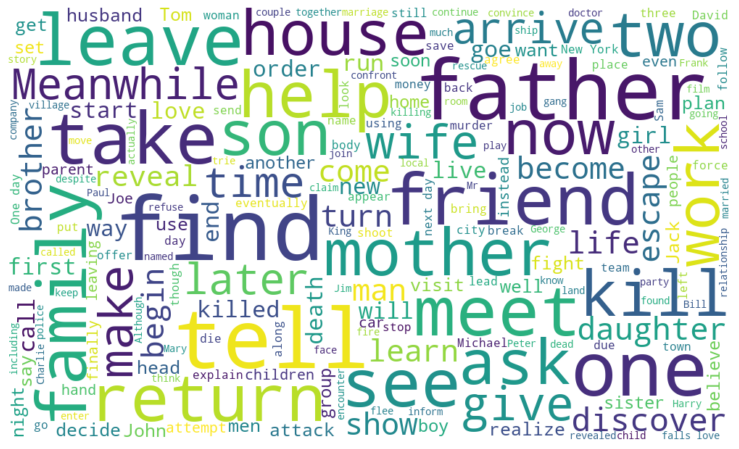

In [25]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      width=1000, 
                      height=600, 
                      max_font_size=120,
                      background_color="white").generate(" ".join(wiki_plots.Plot))

plt.subplots(figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

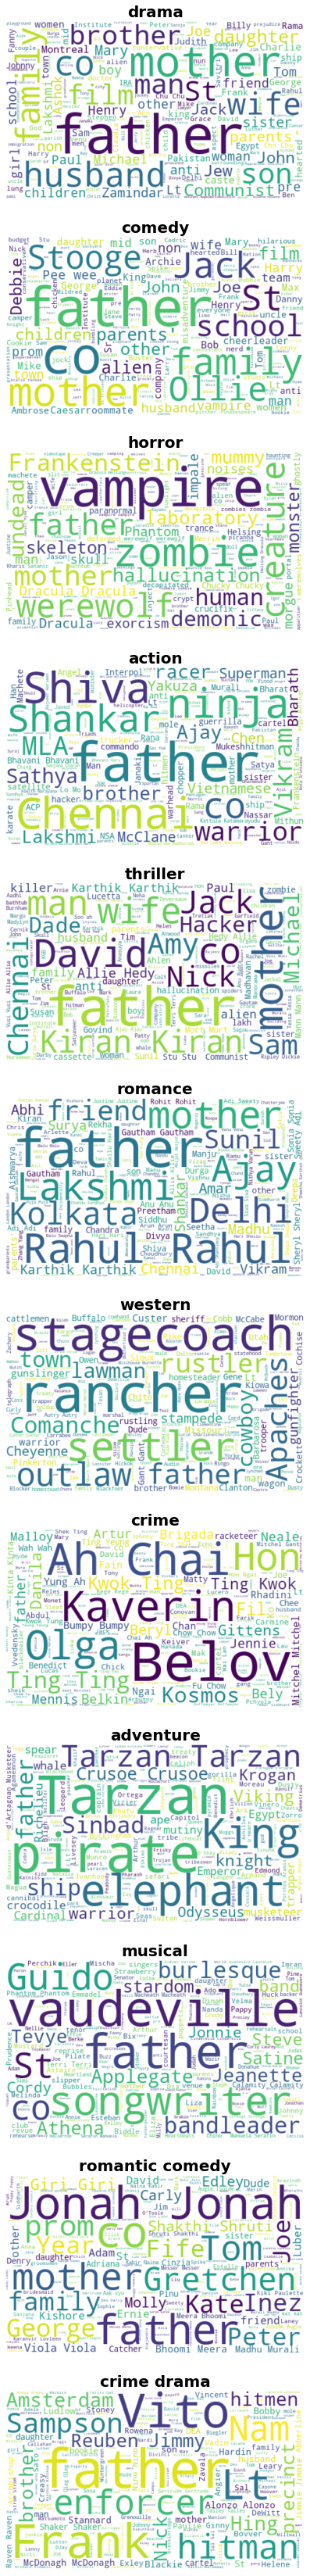

In [30]:
stopwords = set(STOPWORDS)
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(40,60))
#stopwords.update(['father', 'find', 'tell', 'meet', 'one', 'two', 'later', 'goes', 'take', 'finds', 'leave'])

frequent_words = {}
for i, genre in enumerate(wiki_plots.query('Genre != "unknown"')['Genre'].value_counts()[:12].index):
    words = list(set(word_tokenize(" ".join(wiki_plots.loc[wiki_plots.Genre == genre, 'Plot']))))
    for word in words:
        if word in frequent_words:
            frequent_words[word] += 1
        else:
            frequent_words[word] = 1
    
for word in frequent_words.items():
    if word[1] > 7:
        stopwords.add(word[0])

for i, genre in enumerate(wiki_plots.query('Genre != "unknown"')['Genre'].value_counts()[:12].index):
    wordcloud = WordCloud(stopwords=stopwords,
                          width=500, 
                          height=300, 
                          max_font_size=90,
                          background_color="white").generate(" ".join(wiki_plots.loc[wiki_plots.Genre == genre, 'Plot']))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title("{}".format(genre), fontsize=20, weight="bold")
    axes[i].axis('off')